In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# import data
data = pd.read_csv('./data/Alltitles.csv')
data.head()

,Unnamed: 0,title,label
0,0,Epic Games takes on Apple and Google in Austra...,Apple
1,1,Java users on macOS 14 running on Apple silico...,Apple
2,2,Apple With No AI Looks More Like Coca-Cola Tha...,Apple
3,3,"Daily Advice Thread - March 16, 2024",Apple
4,4,"Apple opposes ex-ante regulations, similar to ...",Apple


In [2]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
# map numerical values to strings
data['label']= data['label'].map({'Apple':1, 'Android':0})
data.head()

,title,label
0,Epic Games takes on Apple and Google in Austra...,1
1,Java users on macOS 14 running on Apple silico...,1
2,Apple With No AI Looks More Like Coca-Cola Tha...,1
3,"Daily Advice Thread - March 16, 2024",1
4,"Apple opposes ex-ante regulations, similar to ...",1


In [4]:
data.to_csv('./data/Alltitles_labeled.csv', index=False) # making a copy without index for modelling purpose

In [5]:
X = data['title']
y = data['label']
y.value_counts(normalize = True) # check the distribution of the label

1    0.60665
0    0.39335
Name: label, dtype: float64

In [6]:
cvec = CountVectorizer(stop_words='english')
CVed_X = cvec.fit_transform(X)

In [7]:
# check the shape after count-vectorised into a sparse matrix
CVed_X.shape

(1233, 3096)

### Exploratory Data Analysis

<AxesSubplot: >

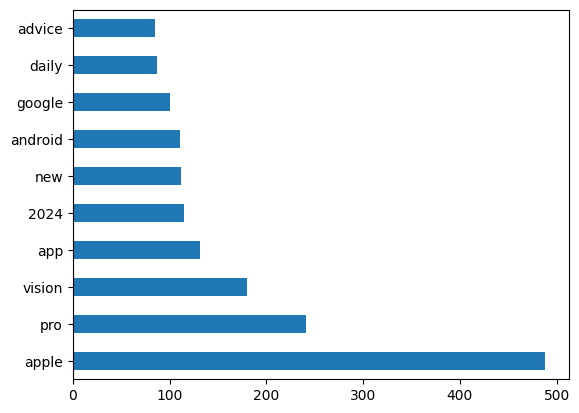

In [8]:
# rank each vector by its values
test_df = pd.DataFrame(CVed_X.todense(), columns=cvec.get_feature_names_out())
test_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')

In [9]:
test_df.columns[:160]

Index(['000', '000mah', '01', '02', '03', '04', '05', '06', '07', '08',
       ...
       'a55', 'a9', 'aaa', 'aawireless', 'ability', 'able', 'absolutely',
       'abused', 'abusive', 'accelerated'],
      dtype='object', length=160)

At the first glancec, it looks like the matrix has decent number of numerical numbers which might not have offered much values to the analysis

In [10]:
test_df.columns[130:160]

Index(['80', '8300', '85bn', '87', '8a', '8g3', '8gb', '8k', '8s', '90',
       '9000', '9300', '9400', '99', '9pro', '9to5google', '9to5mac', 'a17',
       'a25', 'a35', 'a55', 'a9', 'aaa', 'aawireless', 'ability', 'able',
       'absolutely', 'abused', 'abusive', 'accelerated'],
      dtype='object')

However, upon further inspection, the numerical values are associated with phone models such as Samsung Galaxy A25 Android, below are some selected samples

In [11]:
X[X.str.contains('A25')]

997    Samsung Galaxy A25 5G smartphone review - Colo...
Name: title, dtype: object

In [12]:
X[X.str.contains('aaa')]

446    Comparing PC Parts to Apple’s M3 - Part 1 | Ma...
Name: title, dtype: object

In [13]:
X[X.str.contains('85bn')]

702    Apple’s $85bn-a-year services business faces l...
Name: title, dtype: object

Therefore, I decided to keep all of the vectors. I would perform hyperparameter tuning on the vectorizer later, which could potentially remove all these terms that appear only once in the data. 

Now let's explore the different distribution between Apple and Android

In [14]:
# convert all titles into respective arrays for EDA
Apple = data[data['label'] == 1]['title']
Android = data[data['label'] == 0]['title']

In [15]:
Apple

0      Epic Games takes on Apple and Google in Austra...
1      Java users on macOS 14 running on Apple silico...
2      Apple With No AI Looks More Like Coca-Cola Tha...
3                   Daily Advice Thread - March 16, 2024
4      Apple opposes ex-ante regulations, similar to ...
                             ...                        
743              Daily Advice Thread - December 23, 2023
744        Meet the PHOLED That Is Transforming Displays
745    Apple Wants to Partner With Major Publishers t...
746       Apple Explores A.I. Deals With News Publishers
747    Testing Apple M3 Graphics: Gaming on the Mac, ...
Name: title, Length: 748, dtype: object

<AxesSubplot: >

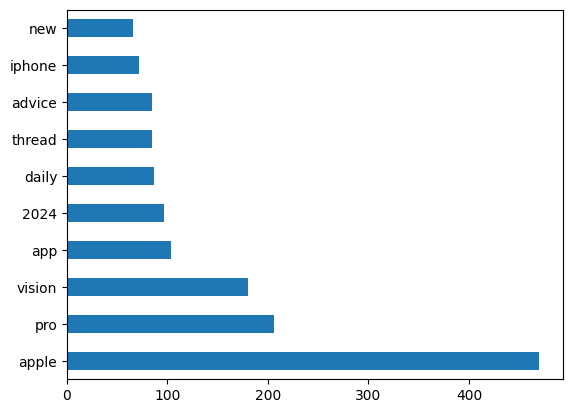

In [16]:
CV_Apple = cvec.transform(Apple)
Apple_df = pd.DataFrame(CV_Apple.todense(), columns=cvec.get_feature_names_out())
Apple_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')

Unsurprisingly, 'apple' appears the most frequently under the Apple subreddit.  
Its latest product Vision Pro seems to still be frequently talked about in the forum.  
  
However, the numerical "2024" might offer some challenges in the later part of the modelling process, as it is too generic.  
It is also worth noting that under the Apple subreddit, it has a post with the title "Daily Advice Thread", which does not offer much classification capability to the model.  

In [17]:
X[X.str.contains('2024')]

3                    Daily Advice Thread - March 16, 2024
10                   Daily Advice Thread - March 15, 2024
16                   Daily Advice Thread - March 14, 2024
24                   Daily Advice Thread - March 13, 2024
32                   Daily Advice Thread - March 12, 2024
                              ...                        
1105    xiaomi 14 series global launch/ultra announcem...
1108    Huawei ranks first in smartphone sales in Chin...
1173    The PC apps for Samsung's Quick Share and Goog...
1189    The Best Smartphone For Photographers in 2024 ...
1223    Shmoocon 2024-Inter-App Collusion:Exploiting A...
Name: title, Length: 115, dtype: object

Above consideration would be important later when we come to the testing of generalisation of the model.

Below we do similar EDA on Andriod's subreddit

<AxesSubplot: >

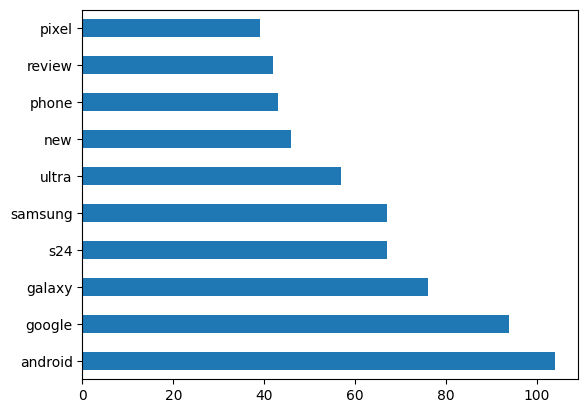

In [18]:
CV_Android = cvec.transform(Android)
Android_df = pd.DataFrame(CV_Android.todense(), columns=cvec.get_feature_names_out())
Android_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')

It looks to have a set of distinctive words for those in the Android subreddit, such as "google", "galaxy" and "samsung".  
Understandable as these name all utilise Android system, while Apple utilises its own IOS system.

So it looks like each of the two subreddits have their own distinctive words, which would help in classifying the respective subreddit.  
In this case, classification model should help us get the job done.